In [1]:
# %pip install matplotlib scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

## Build Lorenz Attractor

In [4]:
sigma = 10
p = 28
beta = 8/3

x0 = [0.1, 0.1, 20]
dt = 0.001

n_points = 100_000

In [5]:
def dx_dt(x, y, z):
    return sigma * (y - x)

def dy_dt(x, y, z):
    return x * (p - z) - y

def dz_dt(x, y, z):
    return x * y - beta * z

def grad_t(point):
    x, y, z = point
    return np.array([
        dx_dt(x, y, z),
        dy_dt(x, y, z),
        dz_dt(x, y, z),
    ])

In [6]:
points = np.zeros((n_points, 3))
grads = np.zeros((n_points, 3))

cur_point = np.array(x0)

for i in range(n_points):
    points[i, :] = cur_point  # add noise
    grad = grad_t(cur_point)
    grads[i, :] = grad  # add noise
    cur_point += grad * dt
    

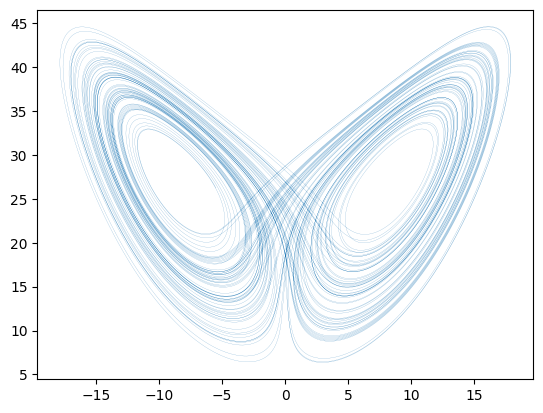

In [7]:
plt.plot(
    points[:, 0],
    points[:, 2],
    "-",
    lw=.1,
)

In [8]:
points.shape, grads.shape

((100000, 3), (100000, 3))

In [9]:
points[10000], grads[10000]

(array([ 7.84911414, 12.13106891, 18.83627227]),
 array([42.81954766, 59.79607602, 44.98808516]))

## Estimate coefs of the system (SINDY)

In [10]:
library = np.zeros((n_points, 10))
library[:, 0] = 1
library[:, 1] = points[:, 0]
library[:, 2] = points[:, 1]
library[:, 3] = points[:, 2]
library[:, 4] = points[:, 0]**2
library[:, 5] = points[:, 1]**2
library[:, 6] = points[:, 2]**2
library[:, 7] = points[:, 0]*points[:, 1]
library[:, 8] = points[:, 0]*points[:, 2]
library[:, 9] = points[:, 1]*points[:, 2]
# Use higher power elements

In [11]:
library.shape

(100000, 10)

In [12]:
n_sample = 100_000
indices = np.random.choice(n_points, n_sample)
X = library[indices]
y = grads[indices]

In [13]:
# Lasso = L1. TODO: Use L0 (#of non-zero coefs)
clf = linear_model.Lasso(
    fit_intercept = False,
    alpha = 0.1,
    max_iter = 10000,
)

clf.fit(
    X=X,
    y=y,
)

Lasso(alpha=0.1, fit_intercept=False, max_iter=10000)

In [14]:
clf.coef_.shape

(3, 10)

In [15]:
clf.coef_

array([[ 0.00000000e+00, -9.38190003e+00,  9.61111235e+00,
         0.00000000e+00, -0.00000000e+00,  1.76034542e-06,
         2.24274787e-05, -0.00000000e+00, -1.71093557e-02,
         1.07987242e-02],
       [-0.00000000e+00,  2.74275505e+01, -6.38433545e-01,
        -0.00000000e+00,  0.00000000e+00, -1.55559835e-06,
        -2.07724254e-05, -0.00000000e+00, -9.84143023e-01,
        -1.00624559e-02],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -2.62218555e+00,  2.52505717e-02,  9.75902418e-03,
        -2.46142009e-03,  9.70441015e-01, -5.73577759e-05,
         3.46663102e-05]])

In [16]:
print(f"sigma: {sigma} original, {-clf.coef_[0][1]} for x, and {clf.coef_[0][2]} for y")
print(f"p: {p} original, {clf.coef_[1][1]} for x")
print(f"xz coef: -1 original, {clf.coef_[1][8]} in dy_dt")
print(f"y coef: -1 original, {clf.coef_[1][2]} in dy_dt")
print(f"xy coef: 1 original, {clf.coef_[2][7]} in dz_dt")
print(f"beta coef: {beta} original, {-clf.coef_[2][3]} in dz_dt")


sigma: 10 original, 9.381900026192257 for x, and 9.611112351213954 for y
p: 28 original, 27.4275504973299 for x
xz coef: -1 original, -0.9841430229173326 in dy_dt
y coef: -1 original, -0.6384335454669551 in dy_dt
xy coef: 1 original, 0.9704410154014074 in dz_dt
beta coef: 2.6666666666666665 original, 2.6221855487476966 in dz_dt


## SVD of one dimention

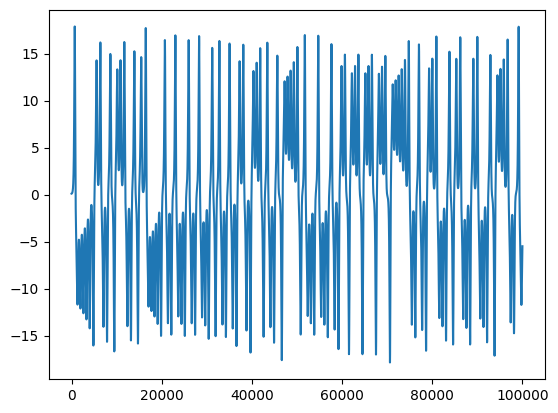

In [17]:
plt.plot(points[:, 0])

### Time delay coordinates

In [21]:
x = points[1_000:, 0]
n_steps = 30_000
X_time_delay = np.zeros((n_steps, n_steps))
coord_stride = 1

for i in range(n_steps):
    X_time_delay[i] = x[np.array(range(i, i+n_steps)) * coord_stride]

In [22]:
X_time_delay.shape

(30000, 30000)

In [23]:
X_time_delay

array([[-3.74841028, -3.77297272, -3.79740121, ...,  4.81284172,
         4.85005575,  4.88756988],
       [-3.77297272, -3.79740121, -3.82169961, ...,  4.85005575,
         4.88756988,  4.92538589],
       [-3.79740121, -3.82169961, -3.84587172, ...,  4.88756988,
         4.92538589,  4.96350555],
       ...,
       [ 4.81284172,  4.85005575,  4.88756988, ..., -0.13919305,
        -0.14486399, -0.1504858 ],
       [ 4.85005575,  4.88756988,  4.92538589, ..., -0.14486399,
        -0.1504858 , -0.15605963],
       [ 4.88756988,  4.92538589,  4.96350555, ..., -0.1504858 ,
        -0.15605963, -0.16158662]])

In [24]:
svd = TruncatedSVD(n_components=3, n_iter=5, random_state=42)
svd.fit(X_time_delay)

TruncatedSVD(n_components=3, random_state=42)

In [25]:
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

[0.06141949 0.06062591 0.04134135]
0.16338674682279825
[58035.52040237 57915.74830708 47611.10769447]


In [41]:
x_new = svd.transform(X_time_delay)

In [42]:
x_new.shape

(30000, 3)

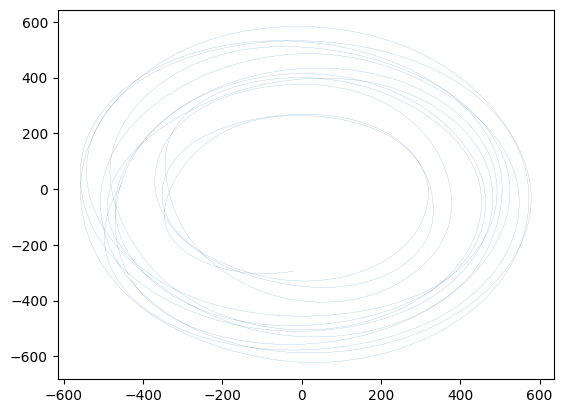

In [43]:
plt.plot(
    x_new[:, 0],
    x_new[:, 1],
    "-",
    lw=.1,
)